In [1]:
!pip install torchvision matplotlib pillow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.2 MB/s eta 0:00:00


In [2]:
from PIL import Image, ImageDraw
import os
import random

# Create folders to save the dataset
os.makedirs("pain_dataset/images", exist_ok=True)
os.makedirs("pain_dataset/labels", exist_ok=True)

# Define pain locations (as rough coordinate boxes)
pain_regions = {
    "head": (70, 10, 130, 50),
    "chest": (60, 60, 140, 120),
    "arm": (10, 60, 50, 160),
    "leg": (70, 170, 130, 240)
}

label_map = {
    "head": 0,
    "chest": 1,
    "arm": 2,
    "leg": 3
}

def draw_body_with_pain_mark(region_name, index):
    # Create a blank image
    img = Image.new("RGB", (200, 250), "white")
    draw = ImageDraw.Draw(img)

    # Draw a stick figure-style body
    draw.rectangle([90, 10, 110, 50], fill="gray")  # Head
    draw.rectangle([80, 50, 120, 150], fill="gray")  # Torso
    draw.rectangle([60, 50, 80, 100], fill="gray")   # Left arm
    draw.rectangle([120, 50, 140, 100], fill="gray") # Right arm
    draw.rectangle([80, 150, 90, 240], fill="gray")  # Left leg
    draw.rectangle([110, 150, 120, 240], fill="gray")# Right leg

    # Draw pain mark
    box = pain_regions[region_name]
    x = random.randint(box[0], box[2])
    y = random.randint(box[1], box[3])
    draw.ellipse([x-5, y-5, x+5, y+5], fill="red")

    # Save image and label
    img.save(f"pain_dataset/images/{index:04d}.png")
    with open(f"pain_dataset/labels/{index:04d}.txt", "w") as f:
        f.write(str(label_map[region_name]))

# Generate dataset
for i in range(400):
    region = random.choice(list(pain_regions.keys()))
    draw_body_with_pain_mark(region, i)

print("✅ Dataset generated: 400 samples with labels.")

✅ Dataset generated: 400 samples with labels.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Label mapping
label_names = ["head", "chest", "arm", "leg"]

# Image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Custom dataset
class PainSketchDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join("pain_dataset/labels", self.images[idx].replace(".png", ".txt"))

        image = Image.open(img_path).convert("RGB")
        with open(label_path, "r") as f:
            label = int(f.read().strip())

        if self.transform:
            image = self.transform(image)

        return image, label

# Load dataset
dataset = PainSketchDataset("pain_dataset/images", "pain_dataset/labels", transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Simple CNN model
class PainClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128), nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        return self.net(x)

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PainClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop
for epoch in range(5):
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(dataset)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")

Epoch 1 | Loss: 20.6929 | Accuracy: 0.2400
Epoch 2 | Loss: 18.0450 | Accuracy: 0.2475
Epoch 3 | Loss: 17.6783 | Accuracy: 0.4275
Epoch 4 | Loss: 15.6022 | Accuracy: 0.7425
Epoch 5 | Loss: 8.7823 | Accuracy: 0.9975


Sample image: 0203.png


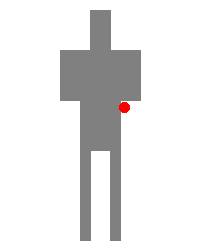

In [5]:
import os
from random import choice
from IPython.display import Image as IPyImage, display

sample_file = choice(os.listdir("pain_dataset/images"))
print("Sample image:", sample_file)

display(IPyImage(filename=f"pain_dataset/images/{sample_file}"))

Saving rib.png to rib.png


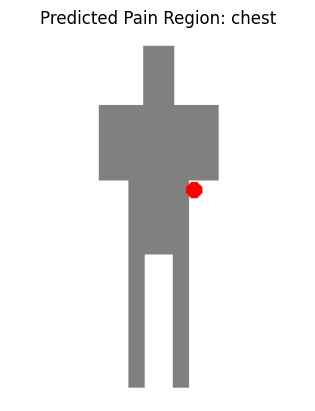

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Use label mapping from before
label_names = ["head", "chest", "arm", "leg"]

# Upload a test image
from google.colab import files
uploaded = files.upload()

# Load and transform the uploaded image
test_img_path = list(uploaded.keys())[0]
test_img = Image.open(test_img_path).convert("RGB")
input_tensor = transform(test_img).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = output.argmax(1).item()

# Show prediction
plt.imshow(test_img)
plt.axis('off')
plt.title(f"Predicted Pain Region: {label_names[pred_class]}")
plt.show()